In [1]:
import os
import numpy as np
import tensorflow as tf
#from sklearn.neighbors import NearestNeighbors
import skimage.io


In [2]:
extensions = [".jpg", ".jpeg",".png"]
# Read image
def read_img(filePath):
    return skimage.io.imread(filePath, as_gray=False)

# Read images with common extensions from a directory
def read_imgs_dir(dirPath, extensions):
    args = [os.path.join(dirPath, filename)
            for filename in os.listdir(dirPath)
            if any(filename.lower().endswith(ext) for ext in extensions)]

    imgs = [read_img(arg) for arg in args]
    return imgs,args

import tkinter as tk
from tkinter import filedialog

def get_folder():
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askdirectory()
    return str(file_path)
    
def get_image():
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename()
    temp = []
    temp.append(str(file_path))
    return temp

In [3]:
from multiprocessing import Pool
from skimage.transform import resize

# Apply transformations to multiple images
def apply_transformer(imgs, transformer, parallel=True):
    if parallel:
        pool = Pool()
        imgs_transform = pool.map(transformer, [img for img in imgs])
        pool.close()
        pool.join()
    else:
        imgs_transform = [transformer(img) for img in imgs]
    return imgs_transform

# Normalize image data [0, 255] -> [0.0, 1.0]
def normalize_img(img):
    return img / 255.

# Resize image
def resize_img(img, shape_resized):
    img_resized = resize(img, shape_resized,
                         anti_aliasing=True,
                         preserve_range=True)
    assert img_resized.shape == shape_resized
    return img_resized


In [5]:
#transformer = ImageTransformer(shape_img_resize)
imgs_train,path_train = read_imgs_dir(get_folder(), extensions)

#imgs_test = read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
imgs_train[0] = resize_img(imgs_train[0], (512,512,3))
shape_img = imgs_train[0].shape

In [6]:
print(shape_img)

(512, 512, 3)


In [7]:
model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,
                                        input_shape=shape_img)
#model.summary()

shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
n_epochs = None

In [8]:
img_transformed = []
for img in imgs_train:
    img_temp = resize_img(img,shape_img_resize )
    img_temp = normalize_img(img_temp)
    img_transformed.append(img_temp)
X_train = np.array(img_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))

 -> X_train.shape = (1, 512, 512, 3)


In [9]:
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model))) #final vector

In [10]:
imgs_test , path_test = read_imgs_dir(get_folder(), extensions)

In [11]:
#print(path_test)

In [12]:
from scipy.spatial.distance import cdist
sims = []
for i in range(len(imgs_test)):
    img = imgs_test[i]
    img_transformed_test = []
    img_temp = resize_img(img,shape_img_resize )
    img_temp = normalize_img(img_temp)
    img_transformed_test.append(img_temp)
    X_test = np.array(img_transformed_test).reshape((-1,) + input_shape_model)
    E_test = model.predict(X_test)
    E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model))) #final vector
    sims.append((1 - cdist(E_train_flatten, E_test_flatten, 'cosine')[0][0],path_test[i]))
    i += 1

In [13]:
res = sorted(sims, key=lambda tup: tup[0], reverse=True)

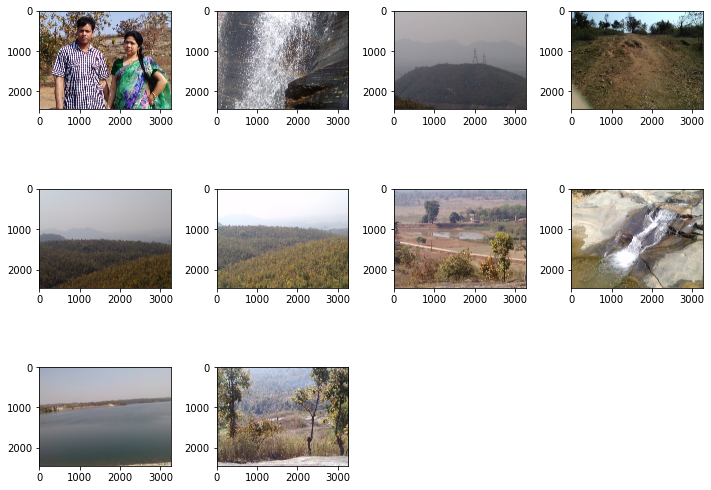

In [15]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0
for i in range(10):
    b = img.imread(res[i][1])
    axes.append(fig.add_subplot(rows,cols,i+1))
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()